In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [9]:
# Get columns for Measurment table

cols = Measurement.__table__.columns
for col in cols:
    print(col)

measurement.id
measurement.station
measurement.date
measurement.prcp
measurement.tobs


In [10]:
# Get columns for Station table

cols = Station.__table__.columns
for col in cols:
    print(col)

station.id
station.station
station.name
station.latitude
station.longitude
station.elevation


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.

session.query(func.max(Measurement.date)).all()


[('2017-08-23',)]

([<matplotlib.axis.XTick at 0x29d753c4d90>,
 [Text(0, 0, '2016-08-24'),
  Text(91, 0, '2016-11-24'),
  Text(182, 0, '2017-02-24'),
  Text(273, 0, '2017-05-24'),
  Text(364, 0, '2017-08-23')])

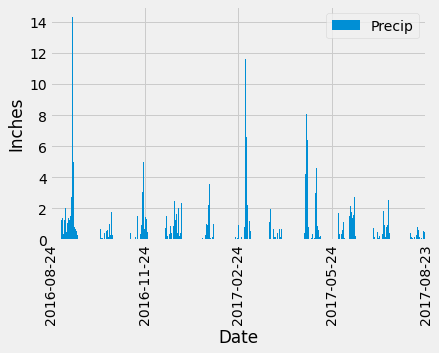

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_text = session.query(func.max(Measurement.date)).all()[0][0]
latest_list = latest_text.split("-")

# Calculate the date one year from the last date in data set.
start_date = dt.date(int(latest_list[0]), int(latest_list[1]), int(latest_list[2])) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
last_year_query = session.query(Measurement.date, Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) > start_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year_query, columns = ['Date', 'Precip'])

last_year_df = last_year_df.set_index('Date')

last_year_df = last_year_df.dropna()

# Sort the dataframe by date
last_year_df = last_year_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
plot_df = last_year_df.groupby('Date').sum()

ax = plot_df.plot.bar(ylabel='Inches', rot='vertical')
plt.xticks(np.arange(0, 365, 91), ['2016-08-24', '2016-11-24', '2017-02-24', '2017-05-24', '2017-08-23'])



In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
count = len(last_year_df.index)
summ_stats_df = pd.DataFrame([('count', count)], columns = ['Stat', 'Precip'])

mean = np.mean(last_year_df['Precip'])
summ_stats_df = summ_stats_df.append({'Stat': 'mean', 'Precip': mean}, ignore_index=True)

std_dev = np.std(last_year_df['Precip'])
summ_stats_df = summ_stats_df.append({'Stat': 'std', 'Precip': std_dev}, ignore_index=True)

min = last_year_df['Precip'].min()
summ_stats_df = summ_stats_df.append({'Stat': 'min', 'Precip': min}, ignore_index=True)

quartiles = last_year_df['Precip'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
midq = quartiles[0.50]
upperq = quartiles[0.75]

summ_stats_df = summ_stats_df.append({'Stat': '25%', 'Precip': lowerq}, ignore_index=True)
summ_stats_df = summ_stats_df.append({'Stat': '50%', 'Precip': midq}, ignore_index=True)
summ_stats_df = summ_stats_df.append({'Stat': '75%', 'Precip': upperq}, ignore_index=True)

max = last_year_df['Precip'].max()
summ_stats_df = summ_stats_df.append({'Stat': 'max', 'Precip': max}, ignore_index=True)

summ_stats_df = summ_stats_df.rename({'Stat': ''}, axis=1)
summ_stats_df = summ_stats_df.set_index('')

summ_stats_df

,Precip
,
count,2015.000000
mean,0.176462
std,0.460174
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
#station_count = session.query(Station).count()
session.query(func.count(Station.id)).limit(1).all()

#print(station_count)

[(9,)]

In [16]:
stations = session.query(Station).all()

for station in stations:
    print(station.id, station.station, station.name)

1 USC00519397 WAIKIKI 717.2, HI US
2 USC00513117 KANEOHE 838.1, HI US
3 USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US
4 USC00517948 PEARL CITY, HI US
5 USC00518838 UPPER WAHIAWA 874.3, HI US
6 USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US
7 USC00519281 WAIHEE 837.5, HI US
8 USC00511918 HONOLULU OBSERVATORY 702.2, HI US
9 USC00516128 MANOA LYON ARBO 785.2, HI US


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
station_activity = session.query(Measurement.station, func.count(Measurement.station).label('readings')).group_by(Measurement.station).all()

# List the stations and the counts in descending order.
station_activity.sort(reverse=True, key=lambda x:x[1])

pprint(station_activity)


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = station_activity[0][0]

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()


[(54.0, 85.0, 71.66378066378067)]

In [19]:
# A more verbose method
most_active = station_activity[0][0]

most_active_station = session.query(Station.name).filter(Station.station == most_active).all()
print(f"The most active station is {most_active_station[0][0]}.")
print()

active_station_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active).all()

most_active_df = pd.DataFrame(active_station_data, columns = ['Date', 'Temp Obs'])

most_active_df = most_active_df.dropna()

low_temp = most_active_df['Temp Obs'].min()

high_temp = most_active_df['Temp Obs'].max()

mean_temp = most_active_df['Temp Obs'].mean()

degree_sign = u'\N{DEGREE SIGN}'

print(f"The lowest temperature was: {low_temp}{degree_sign} Farenheit")
print(f"The highest temperature was: {high_temp}{degree_sign} Farenheit")
print(f"The average temperature was: {mean_temp:.1f}{degree_sign} Farenheit")


The most active station is WAIHEE 837.5, HI US.

The lowest temperature was: 54.0° Farenheit
The highest temperature was: 85.0° Farenheit
The average temperature was: 71.7° Farenheit


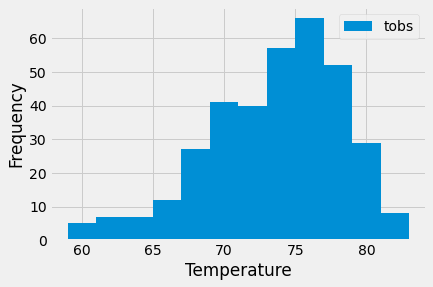

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_temps = session.query(Measurement.tobs).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) > start_date,\
    Measurement.station == most_active).all()

active_temps_list = []

for item in active_temps:
    active_temps_list.append(float(str(item[0])))

plt.hist(active_temps_list, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(['tobs'])
plt.show()

# Close session

In [21]:
# Close Session
session.close()